In [229]:
import json

import pandas as pd
import numpy as np

import string

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from nltk.tokenize import word_tokenize

from numpy import array
from numpy import asarray
from numpy import zeros

In [262]:
import warnings
warnings.filterwarnings("ignore")

In [290]:
df = pd.read_csv('attempt_1.csv',index_col=0)

----

### Preparing data

In [286]:
def clean(x):
    return ''.join([i.lower().strip('\n') for i in x if i not in string.punctuation])

In [291]:
y_array = array([col for col in df['expert']])

In [297]:
df['full_text'] = df['full_text'].apply(clean)

In [306]:
X_tr, X_te, y_train, y_test = train_test_split(
                                    df['full_text'], y_array, test_size=0.2, random_state=0, shuffle=True)

In [307]:
X_train = (X_tr).to_list()
X_test = (X_te).to_list()

----

### Now, going to use a pre training GloVe embedding 

In [154]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

In [155]:
embedded_sentences_train = word_tokenizer.texts_to_sequences(X_train)
embedded_sentences_test = word_tokenizer.texts_to_sequences(X_test)

In [156]:
vocab_length = len(word_tokenizer.word_index) + 1

65077

/Users/ella.franks/opt/anaconda3/envs/tweepy_expert/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


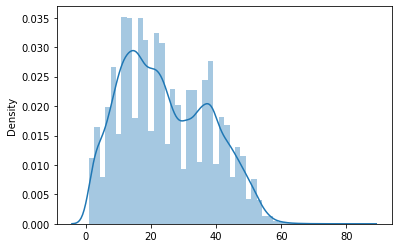

In [157]:
sns.distplot(([len(c.split(' ')) for c in corpus]));

In [158]:
length_long_sentence = 60 

In [159]:
padded_sentences_train = pad_sequences(embedded_sentences_train, length_long_sentence, padding='post')
padded_sentences_test = pad_sequences(embedded_sentences_test, length_long_sentence, padding='post')

In [160]:
embeddings_dictionary = dict()
glove_file = open('/Users/ella.franks/Desktop/Projects/Datasets/glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [161]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

---

### Run a CNN to determine whether a tweet has been written by a tech expert or not

- STILL NEED TO TWEAK THE PARAMETERS 

In [204]:
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)
model.add(embedding_layer)
# model.add(Flatten())
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [205]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 60, 100)           6507700   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 56, 64)            32064     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 6,543,989
Trainable params: 36,289
Non-trainable params: 6,507,700
_________________________________________________________________
None


In [206]:
custom_early_stopping = EarlyStopping(
                        monitor='val_acc', 
                        patience=3, 
                        min_delta=0.001)

In [208]:
model.fit(padded_sentences_train, 
          y_train, 
          epochs=20,
          batch_size = 64,
          steps_per_epoch = 16,
          verbose=1, 
          validation_split=0.2, 
          callbacks=[custom_early_stopping])

Epoch 1/20
16/16 [==============================] - 2s 74ms/step - loss: 0.6211 - acc: 0.6596 - val_loss: 0.5373 - val_acc: 0.7256
Epoch 2/20
16/16 [==============================] - 1s 52ms/step - loss: 0.4993 - acc: 0.7608 - val_loss: 0.4543 - val_acc: 0.8132
Epoch 3/20
16/16 [==============================] - 1s 49ms/step - loss: 0.4339 - acc: 0.8103 - val_loss: 0.3561 - val_acc: 0.8449
Epoch 4/20
16/16 [==============================] - 1s 78ms/step - loss: 0.3482 - acc: 0.8422 - val_loss: 0.3207 - val_acc: 0.8530
Epoch 5/20
16/16 [==============================] - 1s 58ms/step - loss: 0.3326 - acc: 0.8527 - val_loss: 0.3067 - val_acc: 0.8599
Epoch 6/20
16/16 [==============================] - 1s 54ms/step - loss: 0.2971 - acc: 0.8607 - val_loss: 0.2888 - val_acc: 0.8669
Epoch 7/20
16/16 [==============================] - 1s 54ms/step - loss: 0.3345 - acc: 0.8542 - val_loss: 0.2847 - val_acc: 0.8685
Epoch 8/20
16/16 [==============================] - 1s 64ms/step - loss: 0.2720 - a

In [209]:
def plot_history(train, test):
    plt.plot(model.history.history[train], label='train') 
    plt.plot(model.history.history[test], label='test') 
    plt.legend() 
    plt.show()

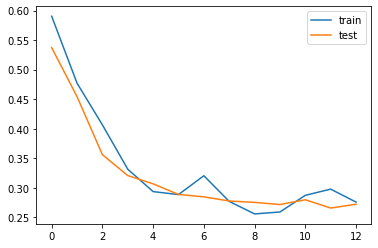

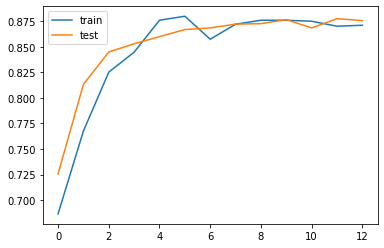

In [210]:
plot_history('loss', 'val_loss'), plot_history('acc', 'val_acc');

In [211]:
model.save("1st_model")

INFO:tensorflow:Assets written to: 1st_model/assets


---

In [ ]:
#LSTM - do another model. 

---

### Using saved model to predict on unseen test set

In [231]:
model_1 = load_model('1st_model')

In [308]:
model_1.evaluate(padded_sentences_test, y_test)

169/169 [==============================] - 1s 3ms/step - loss: 0.2686 - acc: 0.8811


[0.26862576603889465, 0.8810800909996033]

*Performs at 88 percent on the unseen test set*

In [368]:
results = pd.DataFrame({
    'prediction':model_1.predict_classes(padded_sentences_test).max(axis=1), 
    'probability':model_1.predict(padded_sentences_test).max(axis=1), 
    'true_label':y_test,
}, index=X_te.index)

In [369]:
results = pd.merge(results, df, left_index=True, right_index=True)

In [402]:
wrongly_classified = results[results['prediction']!=results['true_label']]
print("The model wrongly classifies {}'s times'".format(wrongly_classified.shape[0]))

The model wrongly classifies 643's times'


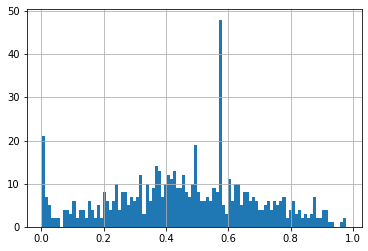

In [406]:
wrongly_classified.probability.hist(bins=100);

In [415]:
wrongly_classified

,prediction,probability,true_label,full_text,created_at,tweet_id,tweet_favourite,tweet_retweet,tweet_lang,tweet_in_reply,...,user_verified,user_follower,user_friend,user_favourite,user_status,user_listed,user_profile_image_url,user_default_profile,user_default_profile_image,expert
21057,1,0.932479,0,i couldnt read the content but i love the head...,2021-01-20 23:22:34,1352033808204218369,27,1,en,NaN,...,0,11597,63,12237,17441,255,https://pbs.twimg.com/profile_images/352604013...,0,0,0
13380,1,0.709821,0,election interference twitter lets ga runoff d...,2020-12-10 21:26:45,1337146760846848002,1,1,en,NaN,...,0,27033,13057,11494,605315,356,https://pbs.twimg.com/profile_images/776457176...,0,0,0
151,0,0.298704,1,with another 25 million in funding julia colli...,2020-12-10 14:01:18,1337034658291310593,15,5,en,NaN,...,1,10142289,962,5858,219108,108622,https://pbs.twimg.com/profile_images/109606660...,0,0,1
4306,0,0.453197,1,in 2 years everyone who is 16 and 17 will be a...,2018-11-07 20:58:08,1060275229921079296,17,1,en,NaN,...,1,17394,1081,135,3338,1418,https://pbs.twimg.com/profile_images/429615069...,0,0,1
7209,0,0.474951,1,thetechscribe maybe name them after your daugh...,2020-12-08 23:41:33,1336455908650405889,3,0,en,14585205.0,...,1,30443,3643,26231,57427,1623,https://pbs.twimg.com/profile_images/968582401...,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,0,0.109426,1,big data gives us more to argue about new on f...,2014-02-03 14:32:24,430348045838848001,0,1,en,NaN,...,0,3656,65,7,1716,326,https://pbs.twimg.com/profile_images/18056932/...,0,0,1
121,0,0.492345,1,disney has plans for 10 marvel shows and 10 st...,2020-12-10 22:58:03,1337169739446153217,53,11,en,NaN,...,1,10142289,962,5858,219108,108622,https://pbs.twimg.com/profile_images/109606660...,0,0,1
3851,0,0.311023,1,amywebb mcbill antpruitt karstenbondy you may ...,2020-10-02 19:02:54,1312105796944101378,31,4,en,9500242.0,...,1,539892,3040,829,7797,21218,https://pbs.twimg.com/profile_images/128420984...,0,0,1
16274,1,0.669109,0,stop trying to persuade your racist friends an...,2020-12-08 11:34:03,1336272827318587392,0,0,en,NaN,...,0,535,0,0,207923,93,https://pbs.twimg.com/profile_images/205603296...,0,0,0


In [420]:
results[(results['probability'] > 0.4) & (results['probability'] < 0.6)]

,prediction,probability,true_label,full_text,created_at,tweet_id,tweet_favourite,tweet_retweet,tweet_lang,tweet_in_reply,...,user_verified,user_follower,user_friend,user_favourite,user_status,user_listed,user_profile_image_url,user_default_profile,user_default_profile_image,expert
20055,0,0.455593,0,the underlying concepts of the magical decentr...,2021-01-21 23:53:52,1352404076361703424,1,0,en,3.410754e+08,...,0,4927,802,6324,4000,226,https://pbs.twimg.com/profile_images/948389926...,0,0,0
6110,1,0.511199,1,yes disability studies should be a required co...,2020-07-17 19:34:24,1284209858762375172,3,0,en,NaN,...,0,15440,1047,705,4622,795,https://pbs.twimg.com/profile_images/291104071...,0,0,1
5202,1,0.571028,1,✋ httpstcoun3qg91qdo,2020-11-27 13:06:04,1332309718002528260,196,21,und,NaN,...,1,863881,1398,53334,27311,18098,https://pbs.twimg.com/profile_images/127598270...,0,0,1
5893,1,0.571028,1,btbdstarwars httpstcotp09ggvfez,2020-12-08 20:03:18,1336400985699147778,1,0,und,8.592586e+17,...,1,115274,3105,359,152153,8214,https://pbs.twimg.com/profile_images/133532218...,0,0,1
4306,0,0.453197,1,in 2 years everyone who is 16 and 17 will be a...,2018-11-07 20:58:08,1060275229921079296,17,1,en,NaN,...,1,17394,1081,135,3338,1418,https://pbs.twimg.com/profile_images/429615069...,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17474,1,0.571028,0,rrana03 🙋🏽‍♀️khoslaventures httpstcozov1dih5gh,2020-12-07 05:15:48,1335815251871219713,3,0,und,1.213878e+18,...,0,1180,671,8138,1117,48,https://pbs.twimg.com/profile_images/720712561...,0,0,0
14312,1,0.557039,0,speaking of enduserfocused service mesh conten...,2020-12-10 00:33:37,1336831400423665664,9,3,en,NaN,...,0,7134,992,12817,12294,181,https://pbs.twimg.com/profile_images/108083759...,0,0,0
5482,0,0.405037,1,“in a 2017 presentation mckinsey laid out seve...,2020-11-28 23:37:26,1332830993724493824,0,0,en,NaN,...,1,18976,7840,39323,24816,1133,https://pbs.twimg.com/profile_images/474704403...,0,0,1
121,0,0.492345,1,disney has plans for 10 marvel shows and 10 st...,2020-12-10 22:58:03,1337169739446153217,53,11,en,NaN,...,1,10142289,962,5858,219108,108622,https://pbs.twimg.com/profile_images/109606660...,0,0,1


In [418]:
results[(results['probability'] > 0.9) | (results['probability'] < 0.1)]

,prediction,probability,true_label,full_text,created_at,tweet_id,tweet_favourite,tweet_retweet,tweet_lang,tweet_in_reply,...,user_verified,user_follower,user_friend,user_favourite,user_status,user_listed,user_profile_image_url,user_default_profile,user_default_profile_image,expert
19424,0,0.009018,0,apple’s watchos 72 is out offers new health an...,2020-12-15 21:18:02,1338956506184630272,0,1,en,NaN,...,0,6701,203,1157,29452,1,https://pbs.twimg.com/profile_images/132714173...,0,0,0
21057,1,0.932479,0,i couldnt read the content but i love the head...,2021-01-20 23:22:34,1352033808204218369,27,1,en,NaN,...,0,11597,63,12237,17441,255,https://pbs.twimg.com/profile_images/352604013...,0,0,0
2805,1,0.973491,1,rt benioff wow new zealand 0 deaths per 1 mill...,2020-05-15 05:33:58,1261167919494356993,0,131,en,NaN,...,0,16062,736,132,10118,1226,https://pbs.twimg.com/profile_images/99010840/...,0,0,1
20723,0,0.002739,0,online child sex abuse spiked by 31 in 2020 wi...,2021-01-21 10:35:01,1352203038874759168,0,0,en,NaN,...,0,92,0,0,56495,27,https://pbs.twimg.com/profile_images/190787573...,1,0,0
14328,0,0.007288,0,wffhq i like to be detailed on this make an e...,2020-12-10 00:27:03,1336829748266209280,2,1,en,38504863.0,...,0,557,1695,7973,20372,301,https://pbs.twimg.com/profile_images/108706076...,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21828,0,0.003119,0,india asks whatsapp to withdraw new privacy po...,2021-01-20 02:55:00,1351724881415729152,0,0,en,NaN,...,0,4960,890,4485,43724,1501,https://pbs.twimg.com/profile_images/122172373...,0,0,0
10881,0,0.006422,0,a texas evangelist leader has more guts in cal...,2020-12-13 20:28:59,1338219387451392001,4,1,en,NaN,...,1,8746,5504,28847,729,255,https://pbs.twimg.com/profile_images/108965736...,1,0,0
9325,0,0.001649,0,the eu wants new powers to oversee internal wo...,2020-12-15 15:39:39,1338871351474495488,0,0,en,NaN,...,0,133,146,185,5383,5,https://pbs.twimg.com/profile_images/482280088...,1,0,0
13655,0,0.003872,0,check out synopsys latest blog on scientist li...,2020-12-10 17:54:59,1337093470083801091,2,1,en,NaN,...,1,6465,6574,4707,15975,208,https://pbs.twimg.com/profile_images/121961090...,0,0,0


--- 

### Download totally unseen expert data and test whether the model still performs well

*So far, we have only tested these models on the same 100 experts we scraped at the start. It is roughly 89% accurate when classifying these 100 experts vs non experts. However, does the model still perform well when tested on other tech experts not included in the original sample?*

In [ ]:
#downloads experts - totally unseen experts - still eprforms well? 